In [1]:
import pickle
import random
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers import EncoderDecoderModel
from transformers import RobertaTokenizerFast

import matplotlib.pyplot as plt
from datasets import load_metric
from sklearn.model_selection import train_test_split

In [2]:
def init_random_seed(value=42):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    torch.backends.cudnn.deterministic = True
init_random_seed()

In [3]:
DATASETS_PATH = '../input/title-generation/'
MODELS_PATH = './models/'
BATCH_SIZE = 2

# Data Explore and Cleaning

In [4]:
original_train_df = pd.read_csv(DATASETS_PATH + '/train.csv', encoding='utf-8', header=0)
original_train_df

,abstract,title
0,we consider the problem of utility maximizatio...,on optimal investment with processes of long o...
1,in this paper we provide an explicit formula f...,boolean complexes for ferrers graphs
2,"kinesin-5, also known as eg5 in vertebrates is...",relative velocity of sliding of microtubules b...
3,we discuss the transition paths in a coupled b...,bifurcation of transition paths induced by cou...
4,two types of room temperature detectors of ter...,all-electric detectors of the polarization sta...
...,...,...
134995,we consider a minimalistic dynamic model of th...,randomly evolving idiotypic networks: structur...
134996,this is an extended version of a communication...,noncommutative generalization of su(n)-princip...
134997,"in this paper, a new method was developed for ...",initialization of multilayer forecasting artif...
134998,we propose a new approach to analyze data that...,principal arc analysis on direct product manif...


In [5]:
df = pd.read_csv(DATASETS_PATH + '/train.csv', encoding='utf-8', header=0)

In [6]:
df_test = pd.read_csv(DATASETS_PATH + '/test.csv', encoding='utf-8', header=0)

In [7]:
df.drop_duplicates(inplace=True)
df.shape

(105603, 2)

In [8]:
# duplicated abstracts with different titles - not sure what to do about it
df[df.abstract.isin(df.loc[df.iloc[:, 0].duplicated(), 'abstract'])].sort_values('abstract')

,abstract,title
83192,a general class of cosmological models driven ...,exact solutions in nonlocal linear models
54359,a general class of cosmological models driven ...,dynamics in nonlocal linear models in the frie...
37728,a new model for the stock market price analysi...,non - randomness stock market price model
2326,a new model for the stock market price analysi...,non - randomness stock market price model (ame...
124665,a quantum model on the chemically and physical...,a quantum model on chemically-physically induc...
...,...,...
106747,we perform a canonical quantization of gravity...,boost invariance of the gravitational field dy...
48009,we propose a general information-theoretic app...,information-theoretic semi-supervised metric l...
18743,we propose a general information-theoretic app...,seraph: semi-supervised metric learning paradi...
46110,zero-divisors (zds) derived by cayley-dickson ...,placeholder substructures iii: a bit-string-dr...


In [9]:
df = df[~df.abstract.duplicated(keep='first')]

In [10]:
df = df[df.abstract.str.len() > df.title.str.len()]

for to_delete_startswith in ["comment", "rejoinder", "discussion of"]:
    df = df[~df.abstract.str.startswith(to_delete_startswith)]
    df = df[~df.title.str.startswith(to_delete_startswith)]

df = df[~(df.abstract.str.contains("withdrawn", case=False) & (df.abstract.str.len() < 20))]

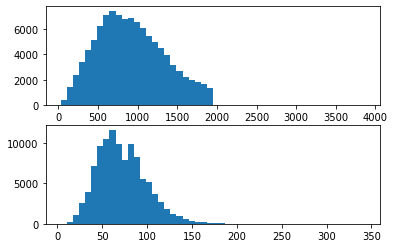

In [11]:
fig, axes = plt.subplots(2, 1)
axes[0].hist(df.iloc[:, 0].str.len(), bins=50);
axes[1].hist(df.iloc[:, 1].str.len(), bins=50);

### Train/Test intersection

In [12]:
df_train_test_intersec = original_train_df[original_train_df.abstract.isin(df_test.abstract)].drop_duplicates()
df_train_test_intersec

,abstract,title
50,"in the present paper, we discuss contra-argume...",some contra-arguments for the use of stable di...
177,we develop a latent variable model and an effi...,spectral learning of large structured hmms for...
364,learning the markov network structure from dat...,learning markov networks with context-specific...
551,"we introduce a stable, well tested python impl...",emcee: the mcmc hammer
661,online and stochastic learning has emerged as ...,online and stochastic douglas-rachford splitti...
...,...,...
133748,we generalize the well-known mixtures of gauss...,extreme deconvolution: inferring complete dist...
133906,this paper develops an active sensing method t...,active sensing of social networks
134037,given an overcomplete dictionary $a$ and a sig...,subspace-sparse representation
134267,current risk mapping models for pooled data fo...,spatial risk mapping for rare disease with hid...


In [13]:
df_train_test_intersec.describe()

,abstract,title
count,433,433
unique,430,433
top,"discussion of ""instrumental variables: an econ...",some contra-arguments for the use of stable di...
freq,3,1


In [14]:
print('Duplicated abstract from train/test intersec:')
df_train_test_intersec[df_train_test_intersec.abstract.isin(df_train_test_intersec.loc[df_train_test_intersec.iloc[:, 0].duplicated(), 'abstract'])].sort_values('abstract')[:20]

Duplicated abstract from train/test intersec:


,abstract,title
14122,"discussion of ""instrumental variables: an econ...",ace bounds; sems with equilibrium conditions
26039,"discussion of ""instrumental variables: an econ...","think globally, act globally: an epidemiologis..."
127670,"discussion of ""instrumental variables: an econ...",causal graphs: addressing the confounding prob...
11680,"to appear to mcmc handbook, s. p. brooks, a. g...",reversible jump markov chain monte carlo
110701,"to appear to mcmc handbook, s. p. brooks, a. g...",likelihood-free markov chain monte carlo


In [15]:
# delete ambigeous abstracts
df_train_test_intersec = df_train_test_intersec[~(df_train_test_intersec.abstract.isin(df_train_test_intersec.loc[df_train_test_intersec.iloc[:, 0].duplicated(), 'abstract']))]

In [16]:
print(f'Part of test data intersected:', df_train_test_intersec.shape[0]/df_test.shape[0])

Part of test data intersected: 0.428


# Dataset building

In [17]:
target_data = df.iloc[:, 1].values
article_data = df.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(article_data, target_data, random_state=42, shuffle=True, test_size=0.01)
len(X_train), len(X_test)

(104044, 1051)

In [18]:
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-large')


Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

In [19]:
tokenizer.vocab_size

50265

In [20]:
# train_encoded_features = [tokenizer(sentence).input_ids for sentence in X_train]
# train_encoded_titles = [tokenizer(sentence).input_ids for sentence in y_train]

# eval_encoded_features = [tokenizer(sentence).input_ids for sentence in X_test]
# eval_encoded_titles = [tokenizer(sentence).input_ids for sentence in y_test]

In [21]:
# with open('encoded_data.pkl', 'wb') as fstream:
#     pickle.dump([train_encoded_features, train_encoded_titles, eval_encoded_features, eval_encoded_titles], fstream)

In [22]:
with open('../input/prepocessed-data/encoded_data.pkl', 'rb') as fstream:
    train_encoded_features, train_encoded_titles, eval_encoded_features, eval_encoded_titles = pickle.load(fstream)

In [23]:
def window_augmentation_(collection, labels):
    for obs_idx, obs in enumerate(collection):
        original_len = len(obs)
        if original_len > 512:
            new_obs = obs[:511]
            new_obs.append(tokenizer.eos_token_id)
            collection[obs_idx] = new_obs
            for i in range(original_len//512):
                new_obs = obs[(i+1) * 255:(i+3) * 255]
                new_obs.insert(0, tokenizer.bos_token_id)
                if new_obs[-1] != tokenizer.eos_token_id:
                    new_obs.append(tokenizer.eos_token_id)
                collection.append(new_obs)
                labels.append(labels[obs_idx])

In [24]:
window_augmentation_(train_encoded_features, train_encoded_titles)
window_augmentation_(eval_encoded_features, eval_encoded_titles)

In [25]:
class SequenceDataset(Dataset):
    def __init__(self, features, targets, max_seq_len=512):
        self.features = features
        self.targets = targets
        self.max_seq_len = max_seq_len
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        features = self.features[idx]
        targets = self.targets[idx]
        if type(idx).__name__ == 'slice':
            features = list(map(torch.LongTensor, features[:self.max_seq_len]))
            targets = list(map(torch.LongTensor, targets[:self.max_seq_len]))
        else:
            features = [torch.tensor(features[:self.max_seq_len], dtype=torch.long)]
            targets = [torch.tensor(targets[:self.max_seq_len], dtype=torch.long)]
        return (features, targets)

In [26]:
train_dataset = SequenceDataset(train_encoded_features, train_encoded_titles)
eval_dataset = SequenceDataset(eval_encoded_features, eval_encoded_titles)

In [27]:
train_dataset[0]

([tensor([    0,  9226,  2225,  6822,    10,  7708,     6,     8, 30718,   157,
             12, 17724,     6,  1548,     7,  1477,     5,  2078,     9, 34751,
          43030,  2239, 16964, 13304,    15, 45113, 24165, 14413,     4, 21437,
            485,  8418,    11, 34751, 35444,  8223,     8,  2239,    19, 14876,
           5990,     6,    52, 15393,  2906,   278,   449,   642,  3245,    36,
           4926,   330,   642,  3245,   238,    61,    67,  3649,    41,  1365,
             12,   560,    12,   757, 40224,  5448,     7,  3438,    50,  3190,
           7931,    19,  9865,  1683,    15,     5, 40150,  5364,     4,    10,
           2007,   414,   477,  4230,  7089,    16,   576,     7,  5368,    10,
          10268, 16522,    13,     5,   414,     6,    19,  8611,    14,    16,
          22635,    30,    10,  3018,    12, 24641,   868, 43797,   479,     5,
           1683,     9,     5, 46194,    15,     5,  1318,     9,     5,   449,
            642,  3245,  2472,     6,   

# Model Upload

In [28]:
from huggingface_hub import notebook_login

notebook_login()


In [29]:
!sudo apt-get install git-lfs
!git lfs install

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 65 not upgraded.
Need to get 3316 kB of archives.
After this operation, 11.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 git-lfs amd64 2.9.2-1 [3316 kB]
Fetched 3316 kB in 1s (2840 kB/s)
Selecting previously unselected package git-lfs.
(Reading database ... 108827 files and directories currently installed.)
Preparing to unpack .../git-lfs_2.9.2-1_amd64.deb ...
Unpacking git-lfs (2.9.2-1) ...
Setting up git-lfs (2.9.2-1) ...
Processing triggers for man-db (2.9.1-1) ...
Error: Failed to call git rev-parse --git-dir: exit status 128 
Git LFS initialized.


In [30]:
# model = EncoderDecoderModel.from_encoder_decoder_pretrained('roberta-base', 'roberta-base', tie_encoder_decoder=True)
model = EncoderDecoderModel.from_pretrained('Remeris/RoBERTaLargeShare_TitleGen', use_auth_token=True)

Downloading:   0%|          | 0.00/4.65k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.70G [00:00<?, ?B/s]

The following encoder weights were not tied to the decoder ['roberta/pooler']
The following encoder weights were not tied to the decoder ['roberta/pooler']


In [31]:
from functools import reduce
# N_parameters
sum(reduce(lambda x, y: x*y,  par.shape) for par in model.parameters())

457272409

In [32]:
model.config.encoder.vocab_size

50265

In [33]:
# set special tokens
model.config.decoder_start_token_id = tokenizer.bos_token_id                                             
model.config.eos_token_id = tokenizer.eos_token_id
model.config.pad_token_id = tokenizer.pad_token_id

# sensible parameters for beam search
# set decoding params                               
model.config.max_length = 512
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 1
model.config.length_penalty = 2.0
model.config.repetition_penalty = 3.0
model.config.num_beams = 1
model.config.vocab_size = model.config.encoder.vocab_size

In [34]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24955 sha256=208c357ad2a43cae5054fad59937965d349d3d41eec1f92e248a6aa4b225dfca
  Stored in directory: /root/.cache/pip/wheels/84/ac/6b/38096e3c5bf1dc87911e3585875e21a3ac610348e740409c76
Successfully built rouge_score


In [35]:
rouge = load_metric('rouge')

In [36]:
def compute_metrics(data):
    ref_ids = data.label_ids
    pred_ids = data.predictions

    pred_decoded = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    ref_decoded = tokenizer.batch_decode(ref_ids, skip_special_tokens=True)
    rouge_scores = rouge.compute(predictions=[pred_decoded], references=[ref_decoded], rouge_types=["rouge1", "rouge2"])
    output = {
        "rouge1_precision": round(rouge_scores['rouge1'].mid.precision, 4),
        "rouge1_recall": round(rouge_scores['rouge1'].mid.recall, 4),
        "rouge1_fmeasure": round(rouge_scores['rouge1'].mid.fmeasure, 4),
        "rouge2_precision": round(rouge_scores['rouge2'].mid.precision, 4),
        "rouge2_recall": round(rouge_scores['rouge2'].mid.recall, 4),
        "rouge2_fmeasure": round(rouge_scores['rouge2'].mid.fmeasure, 4),
    }
    
    return output

In [37]:
# Canceling eval due to the current low perfomance of cpu
training_args = Seq2SeqTrainingArguments(
    output_dir=MODELS_PATH,
    per_device_train_batch_size=3,
    per_device_eval_batch_size=3,
    predict_with_generate=True, 
    evaluation_strategy='epoch',
    logging_strategy='epoch',
    do_train=True,
    do_eval=False,
    warmup_steps=1024,
    num_train_epochs=1,
    save_total_limit=1,
    fp16=True,
    gradient_accumulation_steps=6,
    push_to_hub=True,
    hub_model_id='Remeris/RoBERTaLargeShare_TitleGen',
    hub_strategy='every_save'
)

In [38]:
# torch.nn.utils.rnn.pad_sequence
def custom_collate(data):
    inp_text, snippet_text = [], []
    for features, targets in data:
        inp_text.append(features[0])
        snippet_text.append(targets[0][1:])
    inp_text = torch.nn.utils.rnn.pad_sequence(inp_text, batch_first=True)
    snippet_text = torch.nn.utils.rnn.pad_sequence(snippet_text, batch_first=True)
    return {'input_ids': inp_text, 'labels': snippet_text}

In [39]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [40]:
trainer = Seq2SeqTrainer(
    tokenizer=tokenizer,
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=custom_collate
)

Cloning https://huggingface.co/Remeris/RoBERTaLargeShare_TitleGen into local empty directory.


Download file pytorch_model.bin:   0%|          | 16.0k/1.70G [00:00<?, ?B/s]

Download file runs/Nov11_20-12-14_2ca55e617b96/1668197559.7064607/events.out.tfevents.1668197559.2ca55e617b96.…

Download file runs/Nov11_20-12-14_2ca55e617b96/events.out.tfevents.1668197559.2ca55e617b96.18.0: 100%|########…

Download file runs/Nov12_15-02-08_787c83b1d89f/1668265943.923652/events.out.tfevents.1668265943.787c83b1d89f.1…

Download file runs/Nov12_15-02-08_787c83b1d89f/events.out.tfevents.1668265943.787c83b1d89f.18.0: 100%|########…

Download file training_args.bin: 100%|##########| 3.36k/3.36k [00:00<?, ?B/s]

Clean file runs/Nov12_15-02-08_787c83b1d89f/1668265943.923652/events.out.tfevents.1668265943.787c83b1d89f.18.1…

Clean file runs/Nov11_20-12-14_2ca55e617b96/events.out.tfevents.1668197559.2ca55e617b96.18.0:  13%|#2        |…

Clean file runs/Nov12_15-02-08_787c83b1d89f/events.out.tfevents.1668265943.787c83b1d89f.18.0:  13%|#2        |…

Clean file runs/Nov11_20-12-14_2ca55e617b96/1668197559.7064607/events.out.tfevents.1668197559.2ca55e617b96.18.…

Clean file training_args.bin:  30%|##9       | 1.00k/3.36k [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/1.70G [00:00<?, ?B/s]

Using cuda_amp half precision backend


In [30]:
trainer.train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 133818
  Num Epochs = 4
  Instantaneous batch size per device = 12
  Total train batch size (w. parallel, distributed & accumulation) = 48
  Gradient Accumulation steps = 2
  Total optimization steps = 11152
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.7/site-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:533: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Rouge1 Precision,Rouge1 Recall,Rouge1 Fmeasure,Rouge2 Precision,Rouge2 Recall,Rouge2 Fmeasure
1000,1.416700,1.865357,0.779600,0.659000,0.714200,0.306200,0.258900,0.280600
2000,1.398300,1.787931,0.792200,0.654400,0.716800,0.329400,0.272100,0.298000
3000,1.311600,1.694270,0.797200,0.675800,0.731500,0.341600,0.289600,0.313400
4000,1.215500,1.632421,0.810500,0.672300,0.735000,0.344800,0.286000,0.312700
5000,1.169200,1.582820,0.806400,0.685600,0.741100,0.347200,0.295200,0.319100
6000,1.112700,1.573587,0.816900,0.683200,0.744100,0.355300,0.297200,0.323700
7000,1.047600,1.527549,0.817500,0.688600,0.747500,0.357700,0.301300,0.327100
8000,1.043600,1.494230,0.802100,0.685200,0.739100,0.345700,0.295300,0.318500
9000,0.981600,1.481982,0.829100,0.683500,0.749300,0.364900,0.300800,0.329800
10000,0.963200,1.465341,0.817000,0.692100,0.749400,0.363400,0.307800,0.333300


***** Running Evaluation *****
  Num examples = 1355
  Batch size = 4
***** Running Evaluation *****
  Num examples = 1355
  Batch size = 4
Saving model checkpoint to ./models/checkpoint-2048
Configuration saved in ./models/checkpoint-2048/config.json
Model weights saved in ./models/checkpoint-2048/pytorch_model.bin
tokenizer config file saved in ./models/checkpoint-2048/tokenizer_config.json
Special tokens file saved in ./models/checkpoint-2048/special_tokens_map.json
tokenizer config file saved in ./models/tokenizer_config.json
Special tokens file saved in ./models/special_tokens_map.json
/opt/conda/lib/python3.7/site-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:533: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decod

TrainOutput(global_step=11152, training_loss=1.1435612346041664, metrics={'train_runtime': 17570.2974, 'train_samples_per_second': 30.465, 'train_steps_per_second': 0.635, 'total_flos': 1.3739875444301726e+17, 'train_loss': 1.1435612346041664, 'epoch': 4.0})

In [45]:
trainer.push_to_hub()

Saving model checkpoint to ./models/
Configuration saved in ./models/config.json
Model weights saved in ./models/pytorch_model.bin
tokenizer config file saved in ./models/tokenizer_config.json
Special tokens file saved in ./models/special_tokens_map.json


Upload file pytorch_model.bin:   0%|          | 32.0k/1.70G [00:00<?, ?B/s]

Upload file runs/Nov12_15-02-08_787c83b1d89f/events.out.tfevents.1668265943.787c83b1d89f.18.0: 100%|##########…

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/Remeris/RoBERTaLargeShare_TitleGen
   e33cdcb..273953c  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Sequence-to-sequence Language Modeling', 'type': 'text2text-generation'}}
To https://huggingface.co/Remeris/RoBERTaLargeShare_TitleGen
   273953c..ec11553  main -> main



'https://huggingface.co/Remeris/RoBERTaLargeShare_TitleGen/commit/273953cf955f77283c9c051780dec3ab47b8083a'

In [56]:
for idx in range(5):
    inp = tokenizer(tokenizer.decode(eval_dataset[idx][0][0]), add_special_tokens=False, return_tensors='pt')
    print('Reference:\t', tokenizer.decode(eval_dataset[idx][1][0], skip_special_tokens=True))
    print('Predicted:\t', tokenizer.decode(model.generate(**inp)[0], skip_special_tokens=True))
    print(tokenizer.decode(eval_dataset[idx][0][0], skip_special_tokens=True))
    print()

Reference:	 cocolasso for high-dimensional error-in-variables regression
Predicted:	 cocolasso: a non-convex approach to high dimensional regression
much theoretical and applied work has been devoted to high-dimensional regression with clean data. however, we often face corrupted data in many applications where missing data and measurement errors cannot be ignored. loh and wainwright (2012) proposed a non-convex modification of the lasso for doing high-dimensional regression with noisy and missing data. it is generally agreed that the virtues of convexity contribute fundamentally the success and popularity of the lasso. in light of this, we propose a new method named cocolasso that is convex and can handle a general class of corrupted datasets including the cases of additive measurement error and random missing data. we establish the estimation error bounds of cocolasso and its asymptotic sign-consistent selection property. we further elucidate how the standard cross validation techniq

In [55]:
model.cpu()

EncoderDecoderModel(
  (encoder): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNo

In [34]:
submission_data = pd.read_csv(DATASETS_PATH + '/test.csv')
abstracts = submission_data['abstract'].values

In [35]:
titles = []
for abstract in abstracts:
    model_inp = tokenizer(abstract, return_tensors='pt')
    for key in model_inp:
        model_inp[key] = model_inp[key].to('cuda')
    prediction = model.generate(**model_inp)
    title = tokenizer.decode(prediction[0], skip_special_tokens=True)
    titles.append(title)

In [36]:
titles

['a simple ensembles architecture for sequence transformation',
 'a statistical evaluation of doc2vec for document embedding',
 'a two-way lstm with conditional random fields for sequence tagging',
 'neural machine translation with coverage-based attention',
 'unsupervised image translation',
 'a practical alternative to gan: an algorithm with a beginner',
 'artificial neural network for artistic image creation',
 'imagegan: a domain-specific model for image translation',
 'utility based prediction difficulty for deep learning',
 'flow generation with invertible convolution layers',
 'generating melody generation using convolutional neural networks',
 'towards improved learning of disentangled representations in gan models',
 'adversarial autoencoders with gancoder',
 'generative adversarial networks for quality and disentanglement',
 'unsupervised unassisted image translation with adversarial loss',
 'tutorial: curriculum learning and inference in recurrent neural networks',
 'neural 

In [37]:
submission_df = pd.DataFrame({'abstract': abstracts, 'title': titles})
submission_df.to_csv('predicted_titles.csv', index=False)

In [59]:
model_prediction_df = pd.read_csv('../input/model-preds/predicted_titles.csv')
model_prediction_df

,abstract,title
0,Most sequence transformation models use recurr...,a simple ensembles architecture for sequence t...
1,The doc2vec approach was introduced as an exte...,a statistical evaluation of doc2vec for docume...
2,LSTM models can vary greatly depending on sequ...,a two-way lstm with conditional random fields ...
3,A joint learning process of alignment and tran...,neural machine translation with coverage-based...
4,Current unsupervised image-to-image translatio...,unsupervised image translation
...,...,...
995,subsystem codes are the most versatile class o...,subsystem codes from mds subsystems
996,we study dirac-harmonic maps from degenerating...,generalized energy identity of degenerate dira...
997,in this note we study kloosterman sums twisted...,equidistribution of kloosterman sums modulo mu...
998,we obtain the rate of growth of long strange s...,the rate of decay and long strange segments in...


In [46]:
df_train_test_intersec.loc[df_train_test_intersec.abstract.isin(model_prediction_df.abstract)]

,abstract,title
50,"in the present paper, we discuss contra-argume...",some contra-arguments for the use of stable di...
177,we develop a latent variable model and an effi...,spectral learning of large structured hmms for...
364,learning the markov network structure from dat...,learning markov networks with context-specific...
551,"we introduce a stable, well tested python impl...",emcee: the mcmc hammer
661,online and stochastic learning has emerged as ...,online and stochastic douglas-rachford splitti...
...,...,...
133748,we generalize the well-known mixtures of gauss...,extreme deconvolution: inferring complete dist...
133906,this paper develops an active sensing method t...,active sensing of social networks
134037,given an overcomplete dictionary $a$ and a sig...,subspace-sparse representation
134267,current risk mapping models for pooled data fo...,spatial risk mapping for rare disease with hid...


In [65]:
merged_predictions = model_prediction_df.merge(how='left', on='abstract', right=df_train_test_intersec)

In [68]:
merged_predictions.loc[~merged_predictions.title_y.isna(), 'title_x'] = merged_predictions.loc[~merged_predictions.title_y.isna(), 'title_y']

In [75]:
merged_predictions = merged_predictions.drop('title_y', axis=1).rename(columns={'title_x': 'title'})
merged_predictions


,abstract,title
0,Most sequence transformation models use recurr...,a simple ensembles architecture for sequence t...
1,The doc2vec approach was introduced as an exte...,a statistical evaluation of doc2vec for docume...
2,LSTM models can vary greatly depending on sequ...,a two-way lstm with conditional random fields ...
3,A joint learning process of alignment and tran...,neural machine translation with coverage-based...
4,Current unsupervised image-to-image translatio...,unsupervised image translation
...,...,...
995,subsystem codes are the most versatile class o...,subsystem codes from mds subsystems
996,we study dirac-harmonic maps from degenerating...,generalized energy identity of degenerate dira...
997,in this note we study kloosterman sums twisted...,equidistribution of kloosterman sums modulo mu...
998,we obtain the rate of growth of long strange s...,"long strange segments, ruin probabilities and ..."


In [76]:
merged_predictions.to_csv('predicted_titles.csv', index=False)

In [77]:
import argparse
import string
from nltk.util import ngrams

def generate_csv(input_file='predicted_titles.csv', output_file='submission.csv', voc_file='vocs.pkl'):
    '''
    Generates file in format required for submitting result to Kaggle
    
    Parameters:
        input_file (str) : path to csv file with your predicted titles.
                           Should have two fields: abstract and title
        output_file (str) : path to output submission file
        voc_file (str) : path to voc.pkl file
    '''
    data = pd.read_csv(input_file)
    with open(voc_file, 'rb') as voc_file:
        vocs = pickle.load(voc_file)

    with open(output_file, 'w') as res_file:
        res_file.write('Id,Predict\n')
        
    output_idx = 0
    for row_idx, row in data.iterrows():
        trg = row['title']
        trg = trg.translate(str.maketrans('', '', string.punctuation)).lower().split()
        trg.extend(['_'.join(ngram) for ngram in list(ngrams(trg, 2)) + list(ngrams(trg, 3))])
        
        VOCAB_stoi = vocs[row_idx]
        trg_intersection = set(VOCAB_stoi.keys()).intersection(set(trg))
        trg_vec = np.zeros(len(VOCAB_stoi))    

        for word in trg_intersection:
            trg_vec[VOCAB_stoi[word]] = 1

        with open(output_file, 'a') as res_file:
            for is_word in trg_vec:
                res_file.write('{0},{1}\n'.format(output_idx, int(is_word)))
                output_idx += 1

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument(
        '--input_file',
        help='Path to input .csv file (abstract, title)',
        type=str,
    )
    parser.add_argument(
        '--output_file',
        help='Path to kaggle submission file',
        type=str,
    )
    parser.add_argument(
        '--voc_file',
        help='Path to voc.pkl file',
        type=str,
    )
    args = parser.parse_args()


usage: ipykernel_launcher.py [-h] [--input_file INPUT_FILE]
                             [--output_file OUTPUT_FILE] [--voc_file VOC_FILE]
ipykernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-b8638526-d5d9-4318-b0c4-d7d0bb9a8b2b.json


SystemExit: 2

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3560: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [78]:
!cp ../input/title-generation/vocs.pkl ./

In [79]:
generate_csv('predicted_titles.csv', 'kaggle_pred.csv', 'vocs.pkl')

In [80]:
from IPython.display import FileLink
FileLink(r'kaggle_pred.csv')

/kaggle/working/kaggle_pred.csv

In [54]:
FileLink(r'predicted_titles.csv')

/kaggle/working/predicted_titles.csv

In [41]:
!head kaggle_pred.csv

Id,Predict
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
